<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled174.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit-aer qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import random
import pickle
from datetime import datetime
from google.colab import output
from tqdm.notebook import tqdm
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from google.colab import drive
drive.mount('/content/drive')

class QuantumRandomGenerator:
    def __init__(self, num_bits_precision=64):
        self.simulator = AerSimulator()
        self.num_bits = num_bits_precision
    def get_seed(self):
        qc = QuantumCircuit(self.num_bits, self.num_bits)
        qc.h(range(self.num_bits))
        qc.measure(range(self.num_bits), range(self.num_bits))
        job = self.simulator.run(transpile(qc, self.simulator), shots=1)
        return int(list(job.result().get_counts(0).keys())[0], 2)

class Environment:
    def __init__(self, rng, days_per_cycle=50):
        self.days_per_cycle, self.time, self.rng = days_per_cycle, 0, rng
        self.steps_per_year = 365 * self.days_per_cycle
        self.uv_intensity, self.temperature = self._generate_cycles(num_years=50)

    def _generate_cycles(self, num_years):
        total_steps = num_years * self.steps_per_year
        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, self.days_per_cycle)); daily_uv_cycle[daily_uv_cycle < 0] = 0
        daily_temp_swing = -4 * np.cos(np.linspace(0, 2 * np.pi, self.days_per_cycle))
        base_weather_noise = self.rng.standard_normal(total_steps)
        smoothing_window = np.ones(14 * self.days_per_cycle) / (14 * self.days_per_cycle)
        weather_pattern = np.convolve(base_weather_noise, smoothing_window, 'same') * 5.0

        full_uv, full_temp = [], []
        global_step_counter = 0
        for _ in range(num_years):
            uv_severity = self.rng.uniform(0.6, 1.4)
            seasonal_temp_base = 15 - 10 * np.cos(np.linspace(0, 2 * np.pi, self.steps_per_year))
            seasonal_amplitude_mod = (0.225 * np.sin(np.linspace(0, 2 * np.pi, self.steps_per_year)) + 0.725) * uv_severity
            daily_temp_anomaly = 0
            for i in range(self.steps_per_year):
                if i % self.days_per_cycle == 0: daily_temp_anomaly = self.rng.uniform(-1.5, 1.5)
                cloud_cover_factor = self.rng.uniform(0.7, 1.0)
                daily_uv = daily_uv_cycle[i % self.days_per_cycle] * seasonal_amplitude_mod[i] * cloud_cover_factor
                full_uv.append(daily_uv)
                solar_temp = seasonal_temp_base[i] + daily_temp_swing[i % self.days_per_cycle] + weather_pattern[global_step_counter] + daily_temp_anomaly
                full_temp.append(max(4.0, solar_temp))
                global_step_counter += 1
        return np.array(full_uv), np.array(full_temp)

    def get_current_uv(self): return self.uv_intensity[self.time % len(self.uv_intensity)]
    def get_current_temperature(self): return self.temperature[self.time % len(self.temperature)]
    def step(self): self.time += 1

class Protoribosome:
    def __init__(self, env, strategy, initial_sequence, rng, initial_mass=100.0):
        self.env, self.strategy, self.rna_sequence, self.rng = env, strategy, list(initial_sequence), rng
        self.rna_mass = initial_mass
        self.uv_protection_pool = 50.0
        self.rna_damage_level, self.location, self.status = 0.0, 'shadow_zone', 'ACTIVE'
        self.nmp_pool = {'A': 100, 'U': 100, 'G': 100, 'C': 100}
        self.ndp_pool = {'A': 50,  'U': 50,  'G': 50,  'C': 50}
        self.ntp_pool = {'A': 20,  'U': 20,  'G': 20,  'C': 20}

        if self.strategy == 'cautious': self.uv_damage_rate_per_uv = 1.0
        else: self.uv_damage_rate_per_uv = 1.4
        self.repair_rate, self.uv_protection_factor, self.damage_tolerance_threshold = 0.5, 0.01, 3.0
        self.replication_rate, self.mutation_prob = 0.05, 0.004

    def calculate_protection_score(self):
        score = (len(self.rna_sequence) // 3) * 0.1
        weights = {'UGG':5.0,'UAU':3.0,'UAC':3.0,'UUU':1.5,'UUC':1.5,'UGU':1.0,'UGC':1.0,'AUG':0.75,'CAU':0.5,'CAC':0.5}
        score += sum(weights.get("".join(self.rna_sequence[i:i+3]), 0) for i in range(0, len(self.rna_sequence), 3))
        return score

    def _forage_and_phosphorylate(self, current_uv):
        for base in self.nmp_pool: self.nmp_pool[base] += 5
        for base in self.nmp_pool:
            if self.nmp_pool[base] > 0: self.nmp_pool[base] -= 1; self.ndp_pool[base] += 1
        energy = self.uv_protection_pool * current_uv * 0.1
        conversions = int(energy / 5)
        for _ in range(conversions):
            base = self.rng.choice(list(self.ndp_pool.keys()))
            if self.ndp_pool[base] > 0: self.ndp_pool[base] -= 1; self.ntp_pool[base] += 1

    def _replicate_rna(self):
        if self.status != 'ACTIVE' or self.rna_mass < 80: return None
        required_ntps = {base: self.rna_sequence.count(base) for base in 'AUGC'}
        if not all(self.ntp_pool[base] >= count for base, count in required_ntps.items()):
            return None

        for base, count in required_ntps.items(): self.ntp_pool[base] -= count
        offspring_mass = self.rna_mass * 0.5; self.rna_mass -= offspring_mass
        return Protoribosome(self.env, self.strategy, "".join(self.rna_sequence), self.rng, offspring_mass)

    def step(self, current_uv, dna_template):
        if self.status == 'INACTIVE': return None
        self._forage_and_phosphorylate(current_uv)

        protection = self.uv_protection_pool * self.uv_protection_factor
        effective_uv = current_uv * max(0.01, 1 - protection)
        self.rna_damage_level += effective_uv * self.uv_damage_rate_per_uv
        self.rna_damage_level = max(0, self.rna_damage_level - self.repair_rate)

        has_stop = any("".join(self.rna_sequence[i:i+3]) in {'UAA','UAG','UGA'} for i in range(0,len(self.rna_sequence),3))
        if self.strategy == 'cautious' and has_stop: self.status = 'ARRESTED'
        elif self.strategy == 'readthrough' and has_stop: self.status = 'INACTIVE'

        if self.rna_damage_level > self.damage_tolerance_threshold: self.status = 'INACTIVE'
        if self.status == 'INACTIVE': return None

        self.uv_protection_pool += 0.20 * self.calculate_protection_score()
        return self._replicate_rna()

class Colony:
    def __init__(self, env, dna_template, initial_pop_size, steps_per_day, rng, shuffle_rng):
        self.env, self.dna_template, self.steps_per_day = env, dna_template, steps_per_day
        self.max_population = 10000
        self.rng, self.shuffle_rng = rng, shuffle_rng
        self.active_population = [Protoribosome(env, 'cautious' if i%2==0 else 'readthrough', dna_template, rng) for i in range(initial_pop_size)]

    def step(self, current_step):
        current_uv, current_temp = self.env.get_current_uv(), self.env.get_current_temperature()
        next_generation = [offspring for p in self.active_population if (offspring := p.step(current_uv, self.dna_template)) is not None]
        self.active_population = [p for p in self.active_population if p.status != 'INACTIVE'] + next_generation
        if len(self.active_population) > self.max_population:
            self.active_population = self.rng.choice(self.active_population, self.max_population, replace=False).tolist()

    def get_aggregated_data(self):
        s_keys = ['cautious', 'readthrough']
        p_keys = [f'{s}_{p}_total' for s in s_keys for p in ['nmp','ndp','ntp']]
        data = {key: 0 for key in s_keys + p_keys}
        if not self.active_population: return data
        for p in self.active_population:
            s = p.strategy
            data[s] += 1
            data[f'{s}_nmp_total'] += sum(p.nmp_pool.values())
            data[f'{s}_ndp_total'] += sum(p.ndp_pool.values())
            data[f'{s}_ntp_total'] += sum(p.ntp_pool.values())
        return data

def run_single_simulation(steps_per_day, rng, shuffle_rng, save_path, dna_template):
    colony, start_step, data_log = None, 0, []
    if save_path and os.path.exists(save_path):
        try:
            with open(save_path, 'rb') as f: state = pickle.load(f)
            colony, start_step, data_log = state['colony'], state['step_count'], state['log']
            print(f"--- Resuming simulation from step {start_step} ---")
        except Exception as e: print(f"--- Save file corrupt ({e}). Starting fresh. ---")
    if not colony:
        colony = Colony(Environment(rng, steps_per_day), dna_template, 5000, steps_per_day, rng, shuffle_rng)

    max_run_steps = 3 * colony.env.steps_per_year
    progress_bar = tqdm(desc="Simulating Replica", initial=start_step, total=max_run_steps, leave=False)

    for step_count in range(start_step, max_run_steps):
        agg_data = colony.get_aggregated_data()
        c, r = agg_data.get('cautious',0), agg_data.get('readthrough',0)
        if step_count > 1000 and (c == 0 or r == 0): break
        colony.step(step_count)
        if step_count % 10 == 0: data_log.append({'time':colony.env.time, **agg_data})
        progress_bar.update(1)
        if step_count%25==0:
            c_pools = f"{agg_data['cautious_nmp_total']/1000:.1f}k/{agg_data['cautious_ndp_total']/1000:.1f}k/{agg_data['cautious_ntp_total']/1000:.1f}k"
            r_pools = f"{agg_data['readthrough_nmp_total']/1000:.1f}k/{agg_data['readthrough_ndp_total']/1000:.1f}k/{agg_data['readthrough_ntp_total']/1000:.1f}k"
            progress_bar.set_postfix_str(f"Cautious(NMP/NDP/NTP): {c_pools} | Reckless: {r_pools}")

        if save_path and step_count > 0 and step_count % 500 == 0:
            with open(save_path + ".tmp", 'wb') as f: pickle.dump({'step_count':step_count,'colony':colony,'log':data_log}, f)
            os.replace(save_path + ".tmp", save_path)

    progress_bar.close()
    final_agg = colony.get_aggregated_data()
    final_c, final_r = final_agg.get('cautious',0), final_agg.get('readthrough',0)
    winner = "Cautious" if final_r == 0 else "Reckless" if final_c == 0 else "Tie/Limit"
    summary = {'Winner':winner,'Duration':step_count,'Final Cautious':final_c,'Final Reckless':final_r}
    if save_path: pd.DataFrame(data_log).to_pickle(save_path.replace('.pkl', '.df.pkl'))
    return summary, pd.DataFrame(data_log)

def main_orchestrator(action, num_replicas, steps_per_day):
    BASE_SAVE_DIR = os.path.join('/content/drive/My Drive/Colab Notebooks/Sim_Experiments/')
    os.makedirs(BASE_SAVE_DIR, exist_ok=True)
    all_runs = sorted([d for d in os.listdir(BASE_SAVE_DIR) if d.startswith('Experiment_')])

    experiment_dir = None
    if action == 'fresh_start' or (action == 'resume' and not all_runs):
        if action == 'resume': print("No past experiment found, starting fresh.")
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        experiment_dir = os.path.join(BASE_SAVE_DIR, f"Experiment_{timestamp}")
        os.makedirs(experiment_dir, exist_ok=True)
    else:
        experiment_dir = os.path.join(BASE_SAVE_DIR, all_runs[-1])
    print(f"--- Using experiment: {os.path.basename(experiment_dir)} ---")

    # Removed plotting-specific actions

    all_summaries = []
    DNA_TEMPLATE = "AUGUGUUACUGG"
    for i in range(1, num_replicas + 1):
        print(f"\n--- Processing Replica {i}/{num_replicas} ---")
        replica_dir = os.path.join(experiment_dir, f"Replica_{i}")
        os.makedirs(replica_dir, exist_ok=True)
        replica_save_base = os.path.join(replica_dir, "simulation.pkl")

        if os.path.exists(replica_save_base.replace('.pkl', '.df.pkl')):
            print(f"--- Replica {i} already completed. Skipping. ---")
            continue

        q_rng = QuantumRandomGenerator(29)
        quantum_seed = q_rng.get_seed()
        sim_rng = np.random.default_rng(seed=quantum_seed)
        shuffle_rng = random.Random(quantum_seed)

        summary, details_df = run_single_simulation(steps_per_day, sim_rng, shuffle_rng, replica_save_base, DNA_TEMPLATE)
        summary['Replica'] = i
        all_summaries.append(summary)

    print("\n\n" + "="*80 + "\n" + " EXPERIMENT SUMMARY ".center(80, "="))
    if all_summaries:
        summary_df = pd.DataFrame(all_summaries).set_index('Replica')
        print(summary_df.to_string())
    print("="*80)

if __name__ == "__main__":
    CHOSEN_ACTION = 'resume'
    NUM_REPLICAS = 10
    STEPS_PER_DAY = 10
    main_orchestrator(CHOSEN_ACTION, NUM_REPLICAS, STEPS_PER_DAY)


Mounted at /content/drive
--- Using experiment: Experiment_2025-07-04_17-41-17 ---

--- Processing Replica 1/10 ---
--- Replica 1 already completed. Skipping. ---

--- Processing Replica 2/10 ---
--- Replica 2 already completed. Skipping. ---

--- Processing Replica 3/10 ---
--- Replica 3 already completed. Skipping. ---

--- Processing Replica 4/10 ---
--- Replica 4 already completed. Skipping. ---

--- Processing Replica 5/10 ---
--- Replica 5 already completed. Skipping. ---

--- Processing Replica 6/10 ---
--- Replica 6 already completed. Skipping. ---

--- Processing Replica 7/10 ---
--- Replica 7 already completed. Skipping. ---

--- Processing Replica 8/10 ---
--- Replica 8 already completed. Skipping. ---

--- Processing Replica 9/10 ---
--- Replica 9 already completed. Skipping. ---

--- Processing Replica 10/10 ---
--- Replica 10 already completed. Skipping. ---


============================== EXPERIMENT SUMMARY ==============================


Loading data from simulation.df.pkl...
Successfully loaded DataFrame with 1095 entries.

--- Data Description ---
         time     cautious  readthrough  cautious_nmp_total  \
count  1095.0  1095.000000  1095.000000        1.095000e+03   
mean      0.0  4997.716895  4997.716895        4.395591e+08   
std       0.0    75.549736    75.549736        2.529964e+08   
min       0.0  2500.000000  2500.000000        1.000000e+06   
25%       0.0  5000.000000  5000.000000        2.207600e+08   
50%       0.0  5000.000000  5000.000000        4.395600e+08   
75%       0.0  5000.000000  5000.000000        6.583600e+08   
max       0.0  5000.000000  5000.000000        8.771600e+08   

       cautious_ndp_total  cautious_ntp_total  readthrough_nmp_total  \
count        1.095000e+03         1095.000000           1.095000e+03   
mean         1.103896e+08       369844.748858           4.395591e+08   
std          6.324949e+07         5137.382024           2.529964e+08   
min          5.000000e+05     

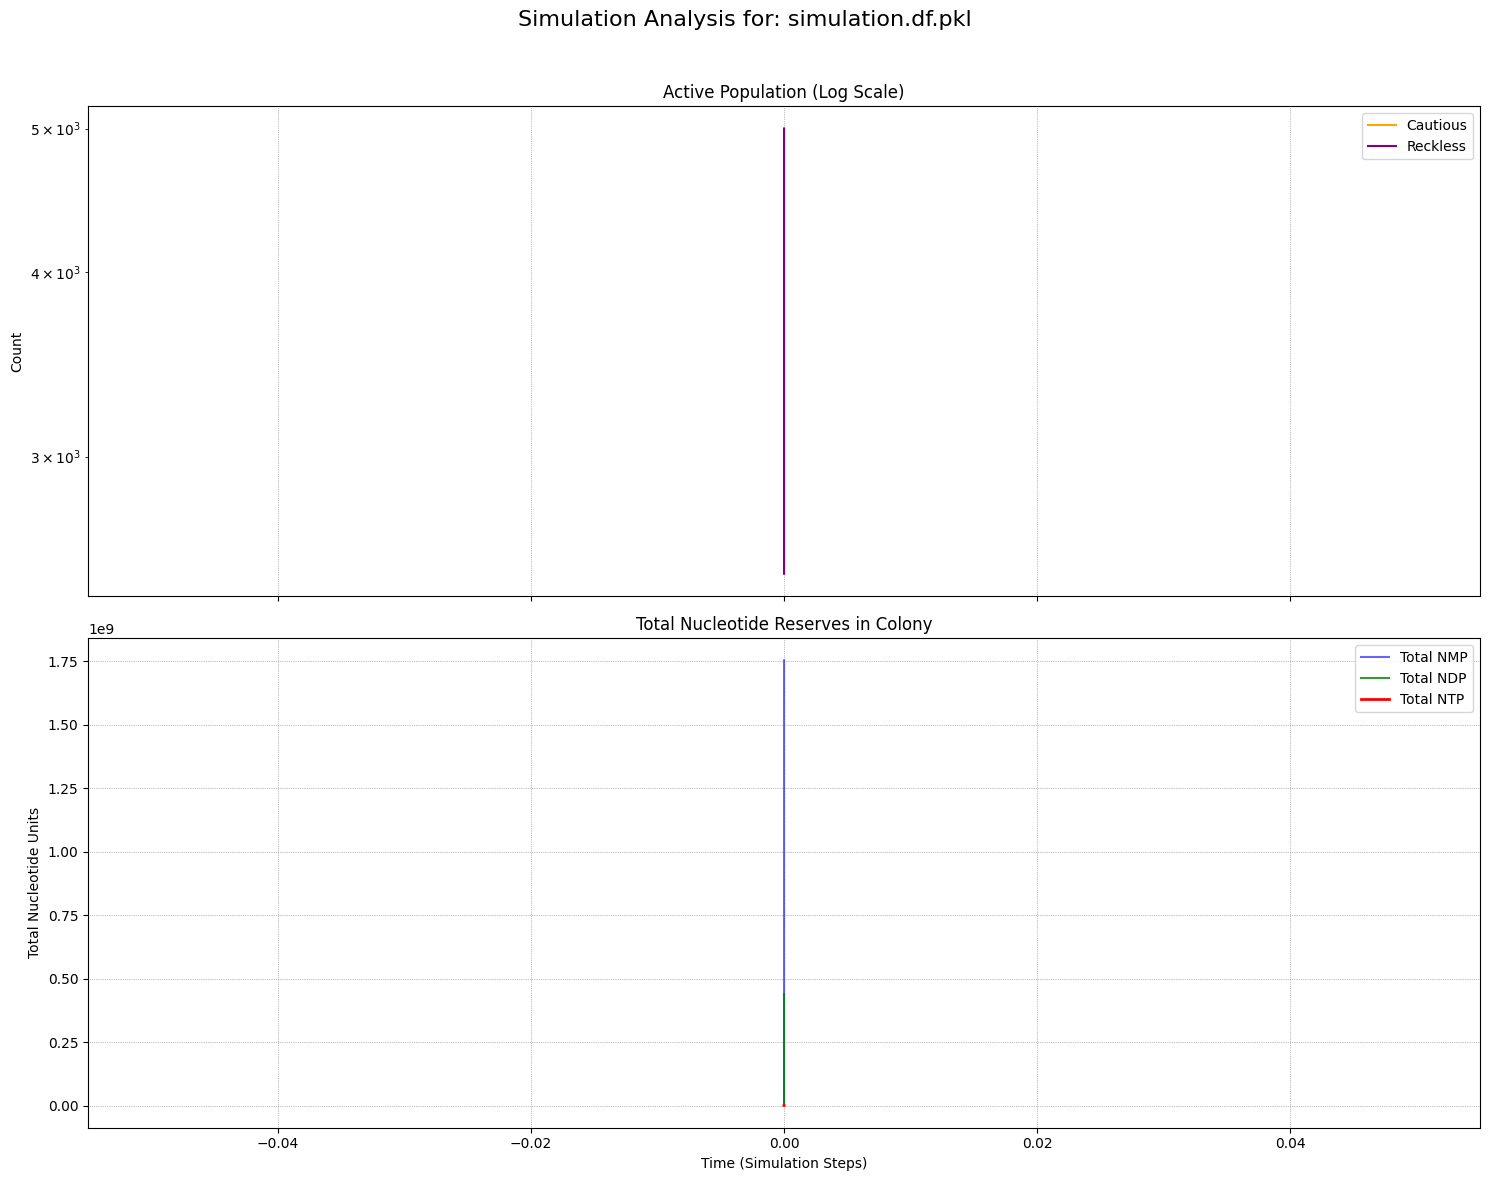

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===================================================================
# === 1. SET THE PATH TO YOUR SIMULATION DATA FILE (.pkl) HERE ===
# ===================================================================
DATA_FILE_PATH = '/content/drive/My Drive/Colab Notebooks/Sim_Experiments/Experiment_2025-07-04_17-41-17/Replica_1/simulation.df.pkl'
# ===================================================================


def plot_simulation_data(file_path):
    """
    Loads a simulation data file and generates all possible plots based on the data it contains.
    """
    # --- 1. Load the Data ---
    if not os.path.exists(file_path):
        print(f"--- ERROR: File not found at: {file_path} ---")
        return

    try:
        print(f"Loading data from {os.path.basename(file_path)}...")
        # Modified to load the .df.pkl file which contains the DataFrame directly
        results_df = pd.read_pickle(file_path)
        print(f"Successfully loaded DataFrame with {len(results_df)} entries.")

        # --- ADDED DIAGNOSTIC LINES ---
        # These lines will print a statistical summary of your data.
        print("\n--- Data Description ---")
        print(results_df.describe())
        print("------------------------\n")
        # ------------------------------

    except Exception as e:
        print(f"\n--- ERROR: Could not load or parse the data file. ---")
        print(f"The error was: {e}")
        return

    # --- 2. Plot the Data ---
    if results_df.empty:
        print("The DataFrame is empty. No data to plot.")
        return

    # Determine which plots can be made
    available_cols = results_df.columns

    # Define required columns for each plot
    plot_reqs = {
        'Environment': ['time', 'uv', 'temp'],
        'Population': ['time', 'cautious', 'readthrough'],
        'Damage & Load': ['time', 'cautious_avg_damage', 'readthrough_avg_damage', 'cautious_stop_pct', 'reckless_stop_pct'],
        'Nucleotide Pools': ['time', 'cautious_nmp_total', 'cautious_ndp_total', 'cautious_ntp_total', 'readthrough_nmp_total', 'readthrough_ndp_total', 'readthrough_ntp_total'],
    }

    # Filter to only the plots we can actually make
    runnable_plots = {name: reqs for name, reqs in plot_reqs.items() if all(col in available_cols for col in reqs)}

    if not runnable_plots:
        print("Could not generate any plots. The data file is missing key columns.")
        print(f"Available columns: {list(available_cols)}")
        return

    num_plots = len(runnable_plots)
    fig, axs = plt.subplots(num_plots, 1, figsize=(15, 6 * num_plots), sharex=True, squeeze=False)
    fig.suptitle(f'Simulation Analysis for: {os.path.basename(file_path)}', fontsize=16)
    colors = {'cautious': 'orange', 'readthrough': 'purple'}
    rolling_window = 100
    plot_idx = 0

    # --- Plot 1: Environmental Conditions ---
    if 'Environment' in runnable_plots:
        ax = axs[plot_idx, 0]
        ax.set_title('Environmental Conditions')
        ax.plot(results_df['time'], results_df['uv'], color='gray', alpha=0.5, label='Daily UV')
        ax.plot(results_df['time'], results_df['uv'].rolling(window=rolling_window, min_periods=1).mean(), color='black', label='UV Trend')
        ax.set_ylabel('UV Intensity'); ax.legend(loc='upper left')
        ax_t = ax.twinx()
        ax_t.plot(results_df['time'], results_df['temp'], color='lightcoral', alpha=0.5, label='Daily Temp')
        ax_t.plot(results_df['time'], results_df['temp'].rolling(window=rolling_window, min_periods=1).mean(), color='red', label='Temp Trend')
        ax_t.set_ylabel('Temperature (°C)', color='r'); ax_t.legend(loc='upper right')
        plot_idx += 1

    # --- Plot 2: Active Population (Log Scale) ---
    if 'Population' in runnable_plots:
        ax = axs[plot_idx, 0]
        ax.set_title('Active Population (Log Scale)')
        ax.plot(results_df['time'], results_df['cautious'], label='Cautious', color=colors['cautious'])
        ax.plot(results_df['time'], results_df['readthrough'], label='Reckless', color=colors['readthrough'])
        ax.set_yscale('log'); ax.set_ylabel('Count'); ax.legend()
        plot_idx += 1

    # --- Plot 3: RNA Damage & Genetic Load ---
    if 'Damage & Load' in runnable_plots:
        ax = axs[plot_idx, 0]
        ax.set_title('RNA Damage & Genetic Load')
        # Corrected column names
        ax.plot(results_df['time'], results_df['cautious_avg_damage'], label='Cautious Avg. Damage', color=colors['cautious'])
        ax.plot(results_df['time'], results_df['readthrough_avg_damage'], label='Reckless Avg. Damage', color=colors['readthrough'], alpha=0.8)
        ax.set_ylabel('Average RNA Damage Level'); ax.legend(loc='upper left')
        ax_t = ax.twinx()
        # Corrected column names
        ax_t.plot(results_df['time'], results_df['cautious_stop_pct'], label='Cautious Stop %', color=colors['cautious'], linestyle='--')
        ax_t.plot(results_df['time'], results_df['reckless_stop_pct'], label='Reckless Stop %', color=colors['readthrough'], linestyle='--')
        ax_t.set_ylabel('Population with Stop Codon (%)'); ax_t.legend(loc='upper right')
        plot_idx += 1

    # --- Plot 4: Nucleotide Pools ---
    if 'Nucleotide Pools' in runnable_plots:
        ax = axs[plot_idx, 0]
        ax.set_title('Total Nucleotide Reserves in Colony')
        # Summing the pools for a total colony view
        c_nmp = results_df['cautious_nmp_total']
        c_ndp = results_df['cautious_ndp_total']
        c_ntp = results_df['cautious_ntp_total']
        r_nmp = results_df['readthrough_nmp_total']
        r_ndp = results_df['readthrough_ndp_total']
        r_ntp = results_df['readthrough_ntp_total']

        ax.plot(results_df['time'], c_nmp + r_nmp, label='Total NMP', color='blue', alpha=0.6)
        ax.plot(results_df['time'], c_ndp + r_ndp, label='Total NDP', color='green', alpha=0.8)
        ax.plot(results_df['time'], c_ntp + r_ntp, label='Total NTP', color='red', lw=2)
        ax.set_ylabel('Total Nucleotide Units'); ax.legend()
        plot_idx += 1

    # --- Final Touches ---
    # Hide any unused subplots
    for i in range(plot_idx, len(axs)):
        axs[i, 0].set_visible(False)

    for i in range(plot_idx):
        axs[i, 0].grid(True, linestyle=':', linewidth='0.5', color='gray')

    plt.xlabel("Time (Simulation Steps)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    plt.close(fig)


# --- Execute the plotting ---
plot_simulation_data(DATA_FILE_PATH)